# Comparativa de datos de Fallecimientos de escovid y Sanidad

## Objetivo

Vamos a hacer una lectura de los fallecimientos comunicados por sanidad en cada uno de los pdf que publica

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [2]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

Definimos variables que nos ayuden en la gestión de los nombres de los ficheros.

In [3]:
codigo_comunidad={'ES-AN':'Andalucia', 'ES-AR':'Aragon', 'ES-AS':'Asturias', 
                  'ES-IB':'Baleares', 'ES-CN':'Canarias','ES-CB':'Cantabria',
                  'ES-CM':'Castilla La Mancha','ES-CL':'Castilla y Leon', 'ES-CT':'Cataluña', 
                  'ES-CE':'Ceuta', 'ES-VC':'C.Valenciana', 'ES-EX':'Extremadura', 
                  'ES-GA':'Galicia', 'ES-MD':'Madrid','ES-ML':'Melilla', 
                  'ES-MC':'Murcia', 'ES-NC':'Navarra', 'ES-PV':'Pais Vasco', 
                  'ES-RI':'La Rioja'}

In [69]:
datadir='datos_sanidad/'
path_escovid19data='https://github.com/montera34/escovid19data/blob/master/data/output/covid19-provincias-spain_consolidated.csv?raw=true'
path_sanidad_pdf='datos_sanidad.csv'
path_sanidad_csv='https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Datos_Casos_COVID19.csv'

In [70]:
columnas_escovid_interes=['date','ccaa', 'deceased','deceased_hosp_eus', 
       'daily_deaths', 'daily_deaths_hosp_eus', 'daily_deaths_inc',
       'daily_deaths_avg3', 'daily_deaths_avg7', 'daily_deaths_avg7_hosp_eus',
       'deaths_last_week']

In [71]:
escovid.columns

Index(['date', 'ccaa', 'deceased', 'deceased_hosp_eus', 'daily_deaths',
       'daily_deaths_hosp_eus', 'daily_deaths_inc', 'daily_deaths_avg3',
       'daily_deaths_avg7', 'daily_deaths_avg7_hosp_eus', 'deaths_last_week'],
      dtype='object')

# Descargamos el  csv de Sanidad

In [211]:
datos=pd.read_csv(path_sanidad,encoding = "ISO-8859-1",skiprows=5,sep=';')

In [212]:
sanidad_csv=datos.copy()

In [213]:
sanidad_csv['Comunidad']=datos.apply(lambda x:codigo_comunidad[x['CCAA_ISO']],axis=1)

In [214]:
for i in sanidad_csv['CCAA_ISO'].unique():
    sanidad_csv.loc[datos['CCAA_ISO']==i,'Fallecidos_acumulados']=sanidad_csv.loc[datos['CCAA_ISO']==i,'Fallecidos'].cumsum()

In [215]:
sanidad_csv.loc[datos['CCAA_ISO']=='ES-AN',:].tail(20)

,CCAA_ISO,Fecha,Casos_Diagnosticados,Hospitalizados,UCI,Fallecidos,Comunidad,Fallecidos_acumulados
4762,ES-AN,07-11-2020,3165,213,12,36,Andalucia,2942.0
4781,ES-AN,08-11-2020,1866,176,16,40,Andalucia,2982.0
4800,ES-AN,09-11-2020,3701,248,11,49,Andalucia,3031.0
4819,ES-AN,10-11-2020,4353,214,23,48,Andalucia,3079.0
4838,ES-AN,11-11-2020,4376,230,15,51,Andalucia,3130.0
4857,ES-AN,12-11-2020,4275,205,12,49,Andalucia,3179.0
4876,ES-AN,13-11-2020,4131,180,9,42,Andalucia,3221.0
4895,ES-AN,14-11-2020,2290,171,4,48,Andalucia,3269.0
4914,ES-AN,15-11-2020,1359,133,13,39,Andalucia,3308.0
4933,ES-AN,16-11-2020,2386,192,17,36,Andalucia,3344.0


In [216]:
sanidad_csv['Fecha']=pd.to_datetime(sanidad_csv['Fecha'],format='%d-%m-%Y')

In [217]:
sanidad_csv.drop(['CCAA_ISO'],axis='columns',inplace=True)

In [218]:
sanidad_csv=sanidad_csv.groupby(['Fecha','Comunidad']).sum()


In [219]:
sanidad_csv=sanidad_csv.reset_index(drop=False)


In [220]:
sanidad_csv=pd.pivot_table(sanidad_csv,index='Fecha',columns='Comunidad',
                           values='Fallecidos_acumulados',aggfunc=sum)

In [221]:
sanidad_csv

Comunidad,Andalucia,Aragon,Asturias,Baleares,C.Valenciana,Canarias,Cantabria,Castilla La Mancha,Castilla y Leon,Cataluña,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco
Fecha,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-22,3581.0,2199.0,856.0,402.0,2248.0,329.0,297.0,3639.0,4414.0,7898.0,54.0,898.0,1154.0,530.0,11265.0,38.0,572.0,849.0,2451.0
2020-11-23,3619.0,2221.0,883.0,402.0,2265.0,334.0,297.0,3649.0,4439.0,7906.0,54.0,904.0,1164.0,533.0,11272.0,38.0,579.0,851.0,2454.0
2020-11-24,3642.0,2242.0,906.0,404.0,2284.0,334.0,298.0,3655.0,4470.0,7909.0,54.0,913.0,1169.0,538.0,11275.0,39.0,587.0,854.0,2460.0


In [245]:
sanidad_csv=sanidad_csv[sanidad_csv.index<='2020-11-25']

In [246]:
sanidad_csv.loc['2020-11-25'].sum()

44180.0

In [247]:
matriz_sanidad = sanidad_csv.copy()

# Descargamos escovid19data

In [400]:
datos_leidos = pd.read_csv(path_escovid19data)

In [401]:
datos_leidos.columns

Index(['date', 'province', 'ine_code', 'ccaa', 'new_cases', 'PCR', 'TestAc',
       'activos', 'hospitalized', 'intensive_care', 'deceased',
       'cases_accumulated', 'cases_accumulated_PCR', 'recovered',
       'deceased_hosp_eus', 'num_casos', 'num_casos_prueba_pcr',
       'num_casos_prueba_test_ac', 'num_casos_prueba_otras',
       'num_casos_prueba_desconocida', 'poblacion', 'cases_per_cienmil',
       'intensive_care_per_1000000', 'deceassed_per_100000',
       'hospitalized_per_100000', 'cases_14days', 'cases_7days',
       'cases_PCR_14days', 'cases_PCR_7days', 'daily_cases',
       'daily_cases_avg7', 'daily_cases_PCR', 'daily_cases_PCR_avg7',
       'daily_deaths', 'daily_deaths_hosp_eus', 'daily_deaths_inc',
       'daily_deaths_avg3', 'daily_deaths_avg7', 'daily_deaths_avg7_hosp_eus',
       'deaths_last_week', 'num_casos_avg7', 'num_casos_prueba_pcr_avg7',
       'ia14', 'source_name', 'source', 'comments'],
      dtype='object')

In [402]:
columnas_escovid_interes

['date',
 'ccaa',
 'deceased',
 'deceased_hosp_eus',
 'daily_deaths',
 'daily_deaths_hosp_eus',
 'daily_deaths_inc',
 'daily_deaths_avg3',
 'daily_deaths_avg7',
 'daily_deaths_avg7_hosp_eus',
 'deaths_last_week']

In [403]:
datos_leidos=datos_leidos[columnas_escovid_interes]

In [404]:
escovid = datos_leidos.groupby(['ccaa','date']).sum().reset_index()

In [405]:
escovid['date']=pd.to_datetime(escovid['date'])

In [406]:
escovid

,ccaa,date,deceased,deceased_hosp_eus,daily_deaths,daily_deaths_hosp_eus,daily_deaths_inc,daily_deaths_avg3,daily_deaths_avg7,daily_deaths_avg7_hosp_eus,deaths_last_week
0,Andalucía,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Andalucía,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Andalucía,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Andalucía,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Andalucía,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
6305,"Rioja, La",2020-11-24,533.0,0.0,3.0,0.0,0.6,2.3,2.6,0.0,16
6306,"Rioja, La",2020-11-25,537.0,0.0,4.0,0.0,0.8,3.3,2.8,0.0,16
6307,"Rioja, La",2020-11-26,543.0,0.0,6.0,0.0,1.1,4.3,3.1,0.0,20
6308,"Rioja, La",2020-11-27,543.0,0.0,0.0,0.0,0.0,3.3,2.8,0.0,17


In [397]:
escovid.loc[escovid['ccaa']=='País Vasco','deceased'].tail(30)

5947    2210.0
5948    2210.0
5949    2210.0
5950    2210.0
5951    2295.0
5952    2295.0
5953    2295.0
5954    2295.0
5955    2295.0
5956    2295.0
5957    2295.0
5958    2399.0
5959    2399.0
5960    2399.0
5961    2399.0
5962    2399.0
5963    2399.0
5964    2399.0
5965    2518.0
5966    2518.0
5967    2518.0
5968    2518.0
5969    2518.0
5970    2518.0
5971    2518.0
5972       0.0
5973       0.0
5974       0.0
5975       0.0
5976       0.0
Name: deceased, dtype: float64

In [407]:
escovid['ccaa'].unique()

array(['Andalucía', 'Aragón', 'Asturias, Principado de', 'Balears, Illes',
       'Canarias', 'Cantabria', 'Castilla - La Mancha', 'Castilla y León',
       'Cataluña', 'Ceuta', 'Comunitat Valenciana', 'Extremadura',
       'Galicia', 'Madrid, Comunidad de', 'Melilla', 'Murcia, Región de',
       'Navarra, Comunidad Foral de', 'País Vasco', 'Rioja, La'],
      dtype=object)

In [408]:
#escovid.loc[escovid['ccaa']=='País Vasco','deceased']=\
#escovid.loc[escovid['ccaa']=='País Vasco','deceased_hosp_eus']

In [409]:
escovid.loc[escovid['ccaa']=='País Vasco','deceased']

5645    0.0
5646    0.0
5647    0.0
5648    0.0
5649    0.0
       ... 
5972    0.0
5973    0.0
5974    0.0
5975    0.0
5976    0.0
Name: deceased, Length: 332, dtype: float64

In [410]:
escovid

,ccaa,date,deceased,deceased_hosp_eus,daily_deaths,daily_deaths_hosp_eus,daily_deaths_inc,daily_deaths_avg3,daily_deaths_avg7,daily_deaths_avg7_hosp_eus,deaths_last_week
0,Andalucía,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Andalucía,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,Andalucía,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Andalucía,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Andalucía,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
6305,"Rioja, La",2020-11-24,533.0,0.0,3.0,0.0,0.6,2.3,2.6,0.0,16
6306,"Rioja, La",2020-11-25,537.0,0.0,4.0,0.0,0.8,3.3,2.8,0.0,16
6307,"Rioja, La",2020-11-26,543.0,0.0,6.0,0.0,1.1,4.3,3.1,0.0,20
6308,"Rioja, La",2020-11-27,543.0,0.0,0.0,0.0,0.0,3.3,2.8,0.0,17


In [411]:
matriz_escovid=escovid.groupby(['ccaa'])['deceased'].sum()

In [412]:
matriz_escovid=pd.pivot_table(escovid,values='deceased',index='date',columns='ccaa',aggfunc=sum)

In [413]:
matriz_escovid=matriz_escovid[matriz_escovid.index<='2020-11-25']

In [414]:
matriz_escovid['Aragón'].tail(99)

date
2020-08-19    1116.0
2020-08-20       0.0
2020-08-21       0.0
2020-08-22       0.0
2020-08-23    1156.0
               ...  
2020-11-21    2202.0
2020-11-22    2209.0
2020-11-23    2228.0
2020-11-24    2247.0
2020-11-25    2272.0
Name: Aragón, Length: 99, dtype: float64

In [415]:
matriz_escovid = matriz_escovid.applymap(lambda x: np.NaN if x==0 else x)

In [416]:
matriz_escovid

ccaa,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla - La Mancha,Castilla y León,Cataluña,Ceuta,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de",Melilla,"Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
date,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-21,3599.0,2202.0,NaN,401.0,319.0,296.0,3965.0,3495.0,15425.0,52.0,NaN,901.0,1137.0,12203.0,36.0,552.0,842.0,2518.0,NaN
2020-11-22,3617.0,2209.0,859.0,401.0,320.0,297.0,3979.0,3521.0,15462.0,52.0,NaN,907.0,1146.0,12225.0,37.0,557.0,847.0,2518.0,527.0
2020-11-23,3654.0,2228.0,885.0,401.0,321.0,297.0,3998.0,3551.0,15507.0,54.0,2247.0,912.0,1161.0,12257.0,37.0,567.0,852.0,NaN,530.0


# Vamos a igualar la denominación de comunidades para poder hacer correctamente la comparativa

In [194]:
matriz_escovid.columns

Index(['Andalucía', 'Aragón', 'Asturias, Principado de', 'Balears, Illes',
       'Canarias', 'Cantabria', 'Castilla - La Mancha', 'Castilla y León',
       'Cataluña', 'Ceuta', 'Comunitat Valenciana', 'Extremadura', 'Galicia',
       'Madrid, Comunidad de', 'Melilla', 'Murcia, Región de',
       'Navarra, Comunidad Foral de', 'País Vasco', 'Rioja, La'],
      dtype='object', name='ccaa')

In [195]:
matriz_sanidad.columns

Index(['Andalucía', 'Aragón', 'Asturias, Principado de', 'Balears, Illes',
       'Comunitat Valenciana', 'Canarias', 'Cantabria', 'Castilla - La Mancha',
       'Castilla y León', 'Cataluña', 'Ceuta', 'Extremadura', 'Galicia',
       'Rioja, La', 'Madrid, Comunidad de', 'Melilla', 'Murcia',
       'Navarra, Comunidad Foral de', 'Pais Vasco'],
      dtype='object')

In [228]:
conversion_nombre={'Andalucia':'Andalucía', 'Aragon':'Aragón', 'Asturias':'Asturias, Principado de',
       'Baleares':'Balears, Illes', 'C.Valenciana':'Comunitat Valenciana',
       'Canarias':'Canarias', 'Cantabria':'Cantabria', 
       'Castilla La Mancha':'Castilla - La Mancha','Castilla y Leon':'Castilla y León',
       'Cataluña':'Cataluña', 'Ceuta':'Ceuta', 'Extremadura':'Extremadura', 
       'Galicia':'Galicia', 'La Rioja':'Rioja, La', 'Madrid':'Madrid, Comunidad de',
       'Melilla':'Melilla', 'Murcia':'Murcia, Región de', 
        'Navarra':'Navarra, Comunidad Foral de', 'Pais Vasco':'País Vasco'
      }

In [251]:
nueva_denom=[]
for comunidad in matriz_sanidad.columns:
    nueva_denom.append(conversion_nombre[comunidad])
matriz_sanidad.columns=nueva_denom

In [252]:
matriz_sanidad

,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Comunitat Valenciana,Canarias,Cantabria,Castilla - La Mancha,Castilla y León,Cataluña,Ceuta,Extremadura,Galicia,"Rioja, La","Madrid, Comunidad de",Melilla,"Murcia, Región de","Navarra, Comunidad Foral de",País Vasco
Fecha,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-21,3550.0,2188.0,844.0,402.0,2227.0,326.0,296.0,3632.0,4385.0,7891.0,53.0,892.0,1142.0,530.0,11260.0,37.0,563.0,844.0,2443.0
2020-11-22,3581.0,2199.0,856.0,402.0,2248.0,329.0,297.0,3639.0,4414.0,7898.0,54.0,898.0,1154.0,530.0,11265.0,38.0,572.0,849.0,2451.0
2020-11-23,3619.0,2221.0,883.0,402.0,2265.0,334.0,297.0,3649.0,4439.0,7906.0,54.0,904.0,1164.0,533.0,11272.0,38.0,579.0,851.0,2454.0


# y preparamos la misma info en tabla para el gráfico


In [417]:
serie_sanidad = matriz_sanidad.stack().reset_index()
serie_sanidad.columns=['Fecha','Comunidad','Fallecidos']

In [418]:
serie_escovid = matriz_escovid.stack().reset_index()
serie_escovid.columns=['Fecha','Comunidad','Fallecidos']

# Preparamos la matriz de diferencias

In [419]:
matriz_dif=(matriz_escovid-matriz_sanidad)

In [420]:
#dif.reset_index(inplace=True)

In [421]:
matriz_dif

,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla - La Mancha,Castilla y León,Cataluña,Ceuta,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de",Melilla,"Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
date,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-21,49.0,14.0,NaN,-1.0,-7.0,0.0,333.0,-890.0,7534.0,-1.0,NaN,9.0,-5.0,943.0,-1.0,-11.0,-2.0,75.0,NaN
2020-11-22,36.0,10.0,3.0,-1.0,-9.0,0.0,340.0,-893.0,7564.0,-2.0,NaN,9.0,-8.0,960.0,-1.0,-15.0,-2.0,67.0,-3.0
2020-11-23,35.0,7.0,2.0,-1.0,-13.0,0.0,349.0,-888.0,7601.0,0.0,-18.0,8.0,-3.0,985.0,-1.0,-12.0,1.0,NaN,-3.0


In [422]:
matriz_dif.loc['2020-11-25'].sum()

8322.0

In [423]:
dif=matriz_dif.stack().reset_index()

In [424]:
dif.columns=['Fecha','Comunidad','Fallecidos']

In [425]:
dif.index

RangeIndex(start=0, stop=4314, step=1)

In [426]:
dif

,Fecha,Comunidad,Fallecidos
0,2020-03-04,"Madrid, Comunidad de",0.0
1,2020-03-05,"Madrid, Comunidad de",0.0
2,2020-03-06,Aragón,1.0
3,2020-03-06,"Madrid, Comunidad de",0.0
4,2020-03-07,Aragón,1.0
...,...,...,...
4309,2020-11-25,"Madrid, Comunidad de",1031.0
4310,2020-11-25,Melilla,-1.0
4311,2020-11-25,"Murcia, Región de",-6.0
4312,2020-11-25,"Navarra, Comunidad Foral de",-2.0


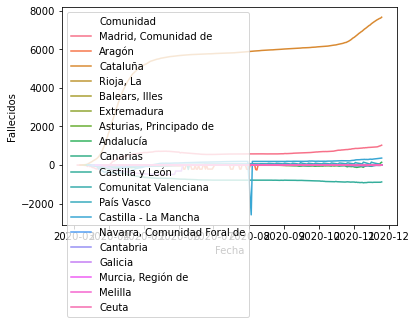

In [427]:
import seaborn as sns

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x='Fecha', y="Fallecidos",
             hue="Comunidad",
             data=dif)

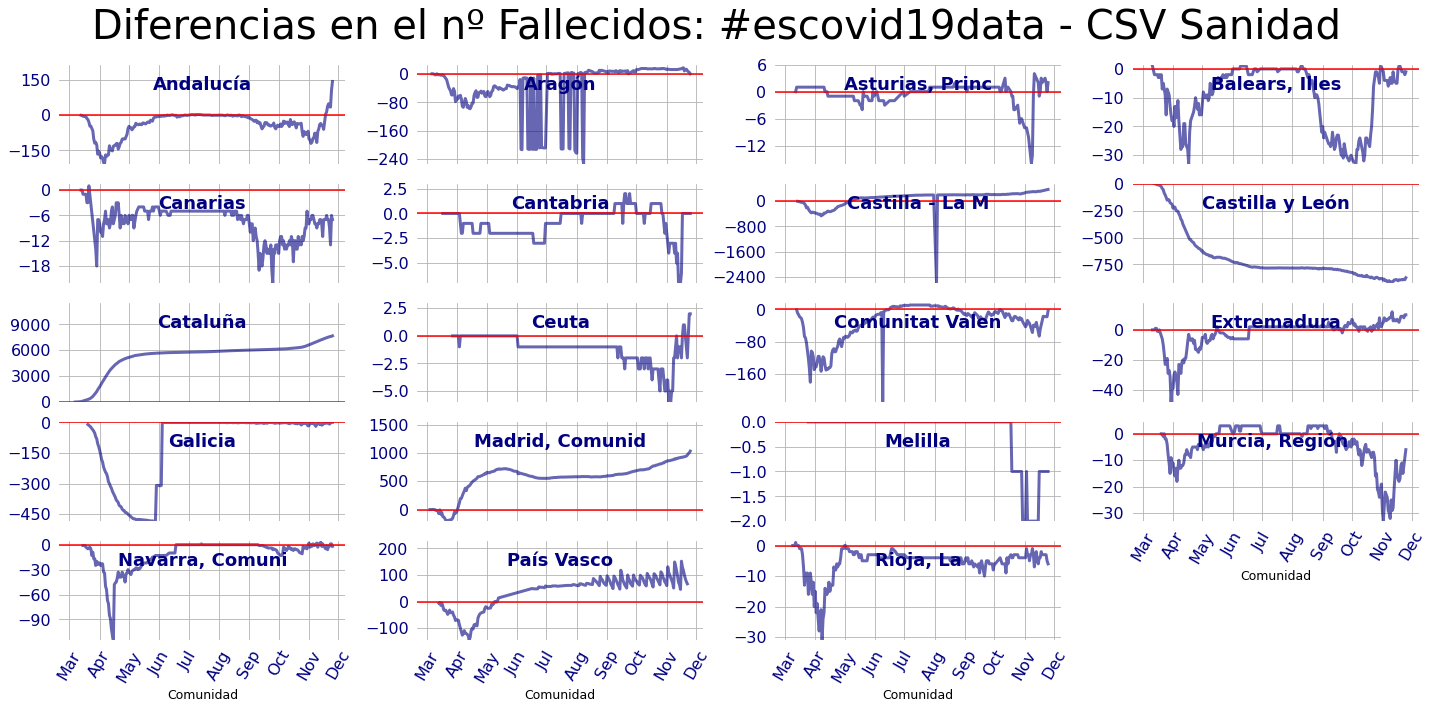

In [439]:

titulo='Diferencias en el nº Fallecidos: #escovid19data - CSV Sanidad'
pal = sns.cubehelix_palette(52, rot=-.25, light=.7)
with sns.plotting_context('paper',font_scale=1.3):
    g = sns.FacetGrid(dif,col='Comunidad', hue='Comunidad',col_wrap=4,aspect=2.5, sharex=True,
                        margin_titles=False,height=2, 
                        sharey=False,palette=pal,col_order=matriz_escovid.columns)


def grafica(x, color, label):
    ax1 = plt.gca()
    
    ax1.text(0.5, .8, label[0:15], fontweight="bold", color='navy',
            ha="center", va="center", size=18,transform=ax1.transAxes)
    sns.lineplot(dif.loc[dif['Comunidad']==label,'Fecha'], 
                 dif.loc[dif['Comunidad']==label,'Fallecidos'],
                 lw=3,color='navy',alpha=.6,ax=ax1)
    #ax1.set_xlim(-1,7)
    ax1.set_ylim(min(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].min()),max(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].max()*1.5))
    #    #ax1.set_yticks(ax1.get_yticks()[1:-2])
    ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=0) 
    ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=60) 
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.1f}{}'.format(v/escala[0],escala[1])))
    XmajorFmt = DateFormatter('%b')
    ax1.xaxis.set_major_formatter(XmajorFmt)
    ax1.axhline(y=0,color='red') 
    ax1.grid(True)
    ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
g.map(grafica,'Comunidad')


g.fig.subplots_adjust(hspace=0)

g.set_titles("")
    
g.despine(bottom=True, left=True)
#g.fig.suptitle('{}'.format(titulo),fontsize=26,color='navy')
g.fig.suptitle(titulo,
                fontsize=40)
g.fig.subplots_adjust(top=.9,wspace=0.25,hspace=.2)   
    
plt.savefig('graficos/comparativa_escovid_sanidadcsv',dpi=288)  
plt.show()

    


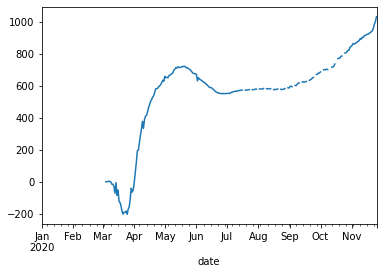

In [343]:
matriz_dif.loc[:,'Madrid, Comunidad de'].plot()

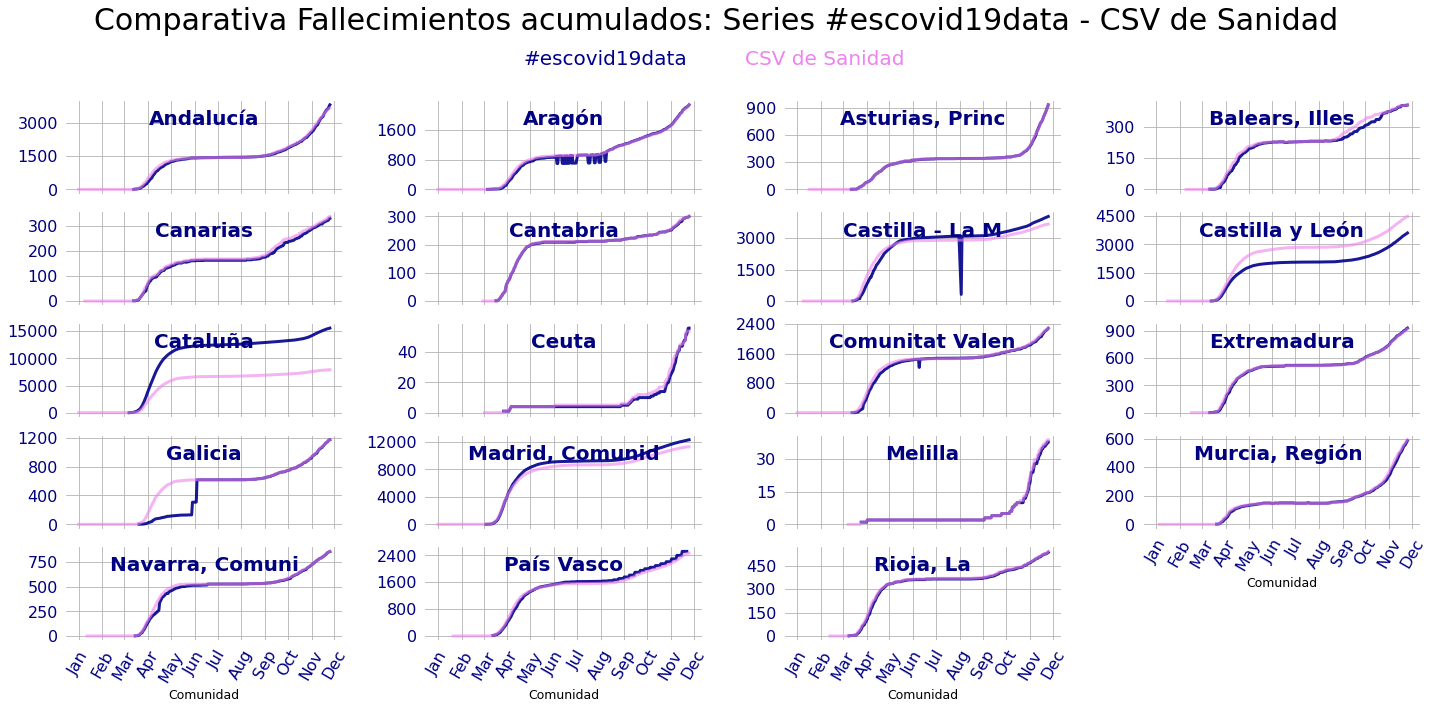

In [433]:

titulo='Comparativa Fallecimientos acumulados: Series #escovid19data - CSV de Sanidad'
pal = sns.cubehelix_palette(52, rot=-.25, light=.7)
with sns.plotting_context('paper',font_scale=1.3):
    g = sns.FacetGrid(dif,col='Comunidad', hue='Comunidad',col_wrap=4,aspect=2.5, sharex=True,
                        margin_titles=False,height=2, 
                        sharey=False,palette=pal,legend_out=True,col_order=matriz_escovid.columns)
    
def grafica(x, color, label):
    ax1 = plt.gca()
    #ax2=ax1.twinx()
    ax1.text(0.5, .8, label[0:15], fontweight="bold", color='navy',
            ha="center", va="center", size=20,transform=ax1.transAxes)
    sns.lineplot(serie_escovid.loc[serie_escovid['Comunidad']==label,'Fecha'], 
                 serie_escovid.loc[serie_escovid['Comunidad']==label,'Fallecidos'],
                 color='darkblue',alpha=.9,ax=ax1,lw=3,label='PDF',legend='full')
    sns.lineplot(serie_sanidad.loc[serie_sanidad['Comunidad']==label,'Fecha'], 
                 serie_sanidad.loc[serie_sanidad['Comunidad']==label,'Fallecidos'],
                 color='violet',alpha=.6,ax=ax1,lw=3,label='csv',legend='full')
    ax1.legend()
   
    #ax1.set_xlim(-1,7)
     #    #ax1.set_yticks(ax1.get_yticks()[1:-2])
    ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=0) 
    ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0,rotation=60) 
    #ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.1f}{}'.format(v/escala[0],escala[1])))
    ax1.set_ylabel('')
    #ax1.axhline(y=0,color='red')
    ax1.grid(True)
    #sns.lineplot(dif.loc[dif['Comunidad']==label,'Fecha'], 
    #             dif.loc[dif['Comunidad']==label,'Fallecidos'],color='magenta',alpha=.6,ax=ax2)
    #ax2.set_ylim(min(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].min()),max(0,dif.loc[dif['Comunidad']==label,'Fallecidos'].max()*1.5))
   
    XmajorFmt = DateFormatter('%b')
    ax1.xaxis.set_major_formatter(XmajorFmt)
    #ax2.yaxis.set_tick_params(labelsize=10,labelcolor='magenta',width=0,rotation=0) 
    #ax2.set_ylabel('')
    #ax2.grid(False)
    #ax2.axhline(y=0,color='red')
    ax1.yaxis.set_major_locator(plt.MaxNLocator(4))



g.map(grafica,'Comunidad')


g.fig.subplots_adjust(hspace=0)

g.set_titles("")
    
g.despine(bottom=True, left=True)
#g.fig.suptitle('{}'.format(titulo),fontsize=26,color='navy')
g.fig.suptitle(titulo,
                fontsize=30)
g.fig.text(0.48, 0.9, "#escovid19data", fontsize=20, color='darkblue', ha ='right')
g.fig.text(0.52, 0.9, "CSV de Sanidad", fontsize=20, color='violet', ha ='left')
g.fig.subplots_adjust(top=.85,wspace=.3,hspace=.2)   
  
plt.savefig('graficos/series_escovidsanidadcsv',dpi=144)  
plt.show()